In [1]:
import os

repo_dir = os.environ.get("REPO_DIR")

code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")

os.chdir(code_dir)

import sys
sys.path.append(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import pickle
import sklearn 
import pandas as pd
from importlib import reload

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import seaborn as sns

from scipy.stats import spearmanr, mode

import geopandas as gpd
import rasterio
import zarr

import gc

import warnings

from mosaiks.utils.imports import *

from mosaiks.utils.io import weighted_groupby
from affine import Affine

import cartopy.crs as ccrs
# Key prediction functions are here
from prediction_utils import (X_matrix_to_demeaned_X,df_to_demeaned_y_vars, flatten_raster,rasterize_df,
make_train_pred_scatterplot as make_scatterplot, cv_solve, solver_kwargs, get_truth_preds_from_kfold_results,
                             predict_y_from_kfold_dict, generalized_demean, upscale_grid_vector)

# Predicting grid level HDI

In this notebook, we generate HDI at the grid level. This notebook is here for reference, but executing it would require the MOSAIKS features at the native tile level (.01 x .01 degrees) for the globe (3TB). We cannot make data of this size easily downloadable.

### First, we need nightlight values at the .01 x .01 degree (tile) level

This file is created in `code/analysis/NL_feature_creation_and_other_NL_processing/nighlight_features_for_hdi_labels_DMSP.ipynb`.

In [2]:
# path = (data_dir + "int/DMSP_NL/"
#            "F182013.v4c_web.stable_lights.avg_vis_converted_to_np-float.tif")

In [3]:
# src = rasterio.open(path)
# arr = src.read(1)
# x,y,vals = flatten_raster(arr, src.transform)
# nl = pd.DataFrame({"lon":x,"lat":y,"nl":vals})

# del x,y,vals,arr

In [4]:
## Convert .00833 res to .01 res

# nl["lon"] = upscale_grid_vector(nl["lon"],2)
# nl["lat"] = upscale_grid_vector(nl["lat"],2)

In [5]:
#nl = nl.groupby(["lon","lat"]).mean().reset_index()

In [6]:
#print(nl["lon"].min(),nl["lon"].max(),nl["lat"].min(),nl["lat"].max())

In [7]:
bins = np.hstack([0,np.linspace(0.0,63,20)])

In [8]:
def binned(a):
    d =  np.histogram(a, bins=bins, density = False, weights=None)
    perc_in_each_bin = d[0]
    return perc_in_each_bin

### Now we also need population weights
This population weights file is created in the `population_weights_for_features_and_grid_preds.ipynb` notebook.

In [9]:
pop = pd.read_pickle(data_dir + "int/GPW_pop/" +
                               "/population_density_global_dense_grid.p")

### We need the country dense grid tiles for each country

In [10]:
# df = pd.read_pickle(data_dir  + "features/prepared_labels/GDL_HDI_polygon_coords_for_featurization.p")
# hdi = pd.read_pickle(data_dir +"int/GDL_HDI/HDI_indicators_and_indices_clean.p")[["Sub-national HDI"]]
# df[["lon","lat"]] = df[["lon","lat"]].round(3)

In [11]:
# df = df.merge(hdi, "left", left_on="GDLCODE", right_index=True)

# df.set_index(["lon","lat"], inplace=True)
# df = df.merge(nl, "left", left_index=True, right_on = ["lon", "lat"])

# del nl

# df = df.merge(pop, "left", on = ["lon", "lat"])

# del pop

# df.set_index(["lon","lat"], inplace=True)

In [12]:
#df.to_pickle(data_dir+"preds/int_grid/dense_grid_df_with_nl_vals_and_pop.p")

df = pd.read_pickle(data_dir+"preds/int_grid/dense_grid_df_with_nl_vals_and_pop.p")

### We also need the country level features that we used to demean in model training

In [13]:
adm1_X = pd.read_pickle(
(data_dir + "features/mosaiks_features/"
"GDL_ADM1_polygon_X_creation_pop_weight=True.p")).drop(columns="GDLCODE")

filepath = (data_dir + "features/nl_features/GDL_HDI_polygons/"
"dmsp_nightlight_features_for_hdi_polygons_20_bins_GPW_pop_weighted.p")
adm1_nl = pd.read_pickle(filepath).loc[adm1_X.index]

In [14]:
X_demean_vectors = X_matrix_to_demeaned_X(adm1_X, return_mean_frame=True )
X_demean_vectors_nl = X_matrix_to_demeaned_X(adm1_nl, return_mean_frame=True )

In [15]:
X_demean_vectors_nl

,perc_pixels_in_bin_0,perc_pixels_in_bin_1,perc_pixels_in_bin_2,perc_pixels_in_bin_3,perc_pixels_in_bin_4,perc_pixels_in_bin_5,perc_pixels_in_bin_6,perc_pixels_in_bin_7,perc_pixels_in_bin_8,perc_pixels_in_bin_9,perc_pixels_in_bin_10,perc_pixels_in_bin_11,perc_pixels_in_bin_12,perc_pixels_in_bin_13,perc_pixels_in_bin_14,perc_pixels_in_bin_15,perc_pixels_in_bin_16,perc_pixels_in_bin_17,perc_pixels_in_bin_18,perc_pixels_in_bin_19
country,,,,,,,,,,,,,,,,,,,,
AFG,0.0,0.840551,0.039241,0.016795,0.008893,0.005107,0.004671,0.004853,0.003268,0.002471,0.004533,0.003040,0.004022,0.004707,0.003878,0.004556,0.005960,0.006518,0.010127,0.026809
AGO,0.0,0.898900,0.009581,0.018237,0.010519,0.004748,0.003442,0.003653,0.001827,0.001948,0.002176,0.001624,0.001073,0.001435,0.001072,0.001049,0.001308,0.001136,0.001237,0.035036
ALB,0.0,0.231302,0.163588,0.122816,0.079891,0.040022,0.026286,0.029880,0.024664,0.021418,0.022175,0.022932,0.014748,0.019182,0.018901,0.017782,0.024882,0.029269,0.029159,0.061105
AND,0.0,0.159024,0.066633,0.062527,0.059371,0.033661,0.031994,0.022992,0.029180,0.017063,0.042260,0.018196,0.024973,0.065966,0.030874,0.030458,0.045160,0.028419,0.088595,0.142654
ARE,0.0,0.150789,0.120240,0.098598,0.056618,0.033828,0.026827,0.032043,0.022168,0.023456,0.030436,0.021964,0.023246,0.026663,0.017598,0.020428,0.027933,0.023035,0.027437,0.216694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VUT,0.0,0.831565,0.030835,0.037447,0.019165,0.011117,0.008962,0.038393,0.014869,0.007271,0.000085,0.000017,0.000028,0.000030,0.000034,0.000049,0.000037,0.000044,0.000037,0.000015
YEM,0.0,0.567345,0.174160,0.047339,0.020402,0.010647,0.008852,0.010189,0.006490,0.005311,0.007064,0.004982,0.005088,0.007095,0.006060,0.006112,0.009645,0.008151,0.012419,0.082649
ZAF,0.0,0.119442,0.061090,0.070549,0.069363,0.041073,0.036224,0.039929,0.027827,0.023567,0.032045,0.021281,0.023571,0.028815,0.021597,0.024588,0.031251,0.027375,0.042398,0.258014


### And finally, we need the primary model used for preds

In [16]:
path = (data_dir + "/model_data/" +
           "within_country_rcf_and_nl_demeaned_solve_all_outcomes_country_fold"
           "_DENSE_pop_weight=True_dmsp_hist_bins_GPW_pop_weighted.pkl")

nl_and_rcf_demeaned_kfold_dict = pickle.load(open(path, "rb"))

### Now we cycle through all the dense grid chunks and produce predictions for those associated with a country

These source files in `z_directory` and the intermediate output files in `int_dir` are not publicly available. They source MOSAIKS features at the 0.01 by 0.01 level total about 3 TB which makes them impractical to share.

In [17]:
# This data directory is outside the GITHUB repo and is not publicy accesible
z_directory = "/shares/maps100/data/features/global_dense_grid/complete/concat/replace_2022/"
int_dir = data_dir + "/preds/int_grid/"

In [18]:
grid_slices = []

for file in os.listdir(z_directory):
    if not file.endswith(".zarr"):
        continue
    print(file)
    
    int_path = int_dir + file.split(".")[0]+"_int_hdi_grid_preds.p"
    
    if os.path.exists(int_path):
        grid_slices.append(pd.read_pickle(int_path))
        continue
    
    z = zarr.load(z_directory + file)
    z = pd.DataFrame(z)
    z = z.rename(columns = {0:"lon",1:"lat"})
    z["lon"], z["lat"] = z["lon"].round(3), z["lat"].round(3)
    
    z_lon_min = z["lon"].min()
    z_lon_max = z["lon"].max()
    print(z_lon_min,z_lon_max)
    
    df_lons = df.reset_index()["lon"].to_numpy()
    
    df_sub = df[ (df_lons <=z_lon_max) & (df_lons>=z_lon_min)].copy()
    
    del df
    
    z.set_index(["lon","lat"], inplace=True)
    
    
    rcf_cols = "X_" + np.arange(4000).astype(str).astype(object)
    z.columns = rcf_cols
    
    subset = df_sub.merge(z, how="inner",left_index=True, right_index=True )
    countries_in_slice = subset["iso_code"].unique()
    
    file_data = []
    for country in countries_in_slice:
        print(country)
    
        country_subset = subset[subset["iso_code"] == country]
    
        ## Demeaned X1 for country
        rcf_X_country = country_subset.loc[:,"X_0":] - X_demean_vectors.loc[country]
        
        X_country_nl = pd.DataFrame(np.vstack(country_subset["nl"].apply(binned)) - X_demean_vectors_nl.loc[country].to_numpy(),
                               index= country_subset.index)
    
    
        country_preds_clipped = predict_y_from_kfold_dict(rcf_X_country,
                           nl_and_rcf_demeaned_kfold_dict,
                           "Sub-national HDI",
                           X_country_nl,
                          clip_preds=True)
        
        country_preds_not_clipped = predict_y_from_kfold_dict(rcf_X_country,
                           nl_and_rcf_demeaned_kfold_dict,
                           "Sub-national HDI",
                           X_country_nl,
                          clip_preds=False)
        
        country_subset.drop(columns = rcf_cols, inplace=True)
        
        country_subset["raw_pred_hdi"] = country_preds_clipped
        country_subset["raw_pred_hdi_not_clipped"] = country_preds_not_clipped
        file_data.append(country_subset)
        gc.collect()
    
    int_output = pd.concat(file_data)
    
    int_output.to_pickle(int_path)
    
    grid_slices.append(int_output)    
    
    gc.collect()
    

vm6_s7.zarr
vm2_s7.zarr
vm6_s9.zarr
vm7_s8.zarr
vm8_s3.zarr
vm8_s2.zarr
vm1_s0.zarr
vm8_s6.zarr
vm6_s2.zarr
vm6_s5.zarr
vm2_s1.zarr
vm9_s8.zarr
vm4_s8.zarr
vm9_s0.zarr
vm9_s5.zarr
vm10_s1.zarr
vm9_s6.zarr
vm3_s9.zarr
vm4_s7.zarr
vm10_s2.zarr
vm10_s0.zarr
vm2_s3.zarr
vm5_s8.zarr
vm2_s4.zarr
vm3_s2.zarr
vm5_s1.zarr
vm2_s2.zarr
vm2_s8.zarr
vm1_s4.zarr
vm7_s2.zarr
vm5_s9.zarr
vm10_s8.zarr
vm7_s0.zarr
vm7_s4.zarr
vm8_s7.zarr
vm3_s0.zarr
vm3_s5.zarr
vm2_s5.zarr
vm5_s2.zarr
vm9_s9.zarr
vm10_s3.zarr
vm2_s0.zarr
vm10_s4.zarr
vm2_s9.zarr
vm6_s0.zarr
vm3_s7.zarr
vm3_s6.zarr
vm8_s1.zarr
vm4_s6.zarr
vm1_s3.zarr
vm4_s4.zarr
vm6_s6.zarr
vm6_s8.zarr
vm5_s5.zarr
vm4_s3.zarr
vm10_s7.zarr
vm2_s6.zarr
vm1_s8.zarr
vm5_s0.zarr
vm5_s3.zarr
vm1_s9.zarr
vm10_s5.zarr
vm3_s3.zarr
vm6_s4.zarr
vm9_s2.zarr
vm8_s5.zarr
vm3_s4.zarr
vm4_s0.zarr
vm7_s6.zarr
vm9_s3.zarr
vm6_s3.zarr
vm9_s7.zarr
vm4_s2.zarr
vm1_s7.zarr
vm9_s1.zarr
vm8_s0.zarr
vm1_s2.zarr
vm1_s6.zarr
vm3_s8.zarr
vm6_s1.zarr
vm7_s5.zarr
vm1_s1.zarr
vm9_s4.z

In [19]:
data = pd.concat(grid_slices)

In [20]:
data.to_pickle(data_dir + "preds/raw_hdi_preds_at_grid.p")

# Now we are going to re-center and up-sample the raw grid estimates

In [21]:
data = pd.read_pickle(data_dir + "preds/raw_hdi_preds_at_grid.p").reset_index()

In [22]:
## Update the values that we center on

In [23]:
data = data.drop(columns="Sub-national HDI")
province_vals = pd.read_pickle(data_dir + "int/GDL_HDI/HDI_indicators_and_indices_clean.p")
data = data.merge(province_vals[["Sub-national HDI"]], "left", left_on="GDLCODE",right_index= True)

In [24]:
data = data.dropna(subset = ["Sub-national HDI"]) # These are missing from our revised 2019 HDI dataset

In [25]:
data # Nans in pop are OK. There really are no data there from GPW

,lon,lat,GDLCODE,iso_code,constant,nl,population,raw_pred_hdi,raw_pred_hdi_not_clipped,Sub-national HDI
0,43.435,-22.915,MDGr117,MDG,1,0.0,37.789425,0.057872,0.057872,0.408
1,43.435,-22.905,MDGr117,MDG,1,0.0,37.789421,-0.001531,-0.001531,0.408
2,43.435,-22.895,MDGr117,MDG,1,0.0,37.789421,0.029665,0.029665,0.408
3,43.435,-22.885,MDGr117,MDG,1,0.0,37.789425,0.028874,0.028874,0.408
4,43.435,-22.875,MDGr117,MDG,1,0.0,37.789421,0.021557,0.021557,0.408
...,...,...,...,...,...,...,...,...,...,...
138168293,-133.505,69.305,CANr102,CAN,1,0.0,NaN,-0.073166,-0.073166,0.931
138168294,-133.505,69.315,CANr102,CAN,1,0.0,NaN,-0.074985,-0.074985,0.931
138168295,-133.505,69.325,CANr102,CAN,1,0.0,NaN,-0.107189,-0.107189,0.931
138168296,-133.505,69.335,CANr102,CAN,1,0.0,NaN,-0.136550,-0.136550,0.931


### Use finer resolution human settlement population. 
We do not want to release predictions for locations where people do not live. For these we will use the Global Human Settlement population data layer available for download at https://ghsl.jrc.ec.europa.eu/download.php?ds=pop

Specifically this is the following data product:

**GHS population grid (R2022)**

Product: GHS-POP, epoch: 2020, resolution: 1 km, coordinate system: Mollweide

#### First we need to re-project from Mollweide to WGS84 

In [26]:
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling

file = "raw/GHS_pop/GHS_POP_E2020_GLOBE_R2022A_54009_1000_V1_0.tif"
dst_crs = 'EPSG:4326'

with rasterio.open(data_dir+file) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rasterio.open(data_dir + "int/GHS_pop/GHS_POP_E2020_GLOBE_R2022A_54009_1000_V1_0_re-project.tif", 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

#### Now we can continue using the GHS Pop product to create a population mask

In [27]:
hsdl = rasterio.open(data_dir + "int/GHS_pop/" +
                      "GHS_POP_E2020_GLOBE_R2022A_54009_1000_V1_0_re-project.tif")

In [28]:
hsdl_arr = hsdl.read(1)

hsdl_df = flatten_raster(hsdl_arr, hsdl.transform)
hsdl_df = pd.DataFrame({"lon":hsdl_df[0],"lat":hsdl_df[1],"hsdl_pop":hsdl_df[2]})

hsdl_df["pop_binary"] = (hsdl_df["hsdl_pop"] > 0).astype(int)

In [29]:
hsdl_df["lon01"] = np.round(np.round(hsdl_df["lon"] + .005,2) - .005,3)
hsdl_df["lat01"] = np.round(np.round(hsdl_df["lat"] + .005,2) - .005,3)
hsdl_df_grp = hsdl_df.groupby(["lon01","lat01"])["pop_binary"].agg(np.nansum).reset_index()

hsdl_df_grp["pop_binary"] = (hsdl_df_grp["pop_binary"] > 0).astype(int)

In [30]:
## Crop the flat raster bounds to be the same as the prediction bounds. Will result in identically shaped rasters
hsdl_df_grp = hsdl_df_grp[ (hsdl_df_grp["lat01"] >= data["lat"].min() ) & \
                          (hsdl_df_grp["lat01"] <= data["lat"].max())]

In [31]:
## Save intermediate output
hsdl_df_grp.to_pickle(data_dir + "int/GHS_pop/hsdl_pop_at_01_grid.p")
hsdl_df_grp = pd.read_pickle(data_dir + "int/GHS_pop/hsdl_pop_at_01_grid.p")

In [32]:
data = data.merge(hsdl_df_grp, 
                   "left", left_on = ["lon","lat"], right_on=["lon01","lat01"])

In [33]:
## Save a second intermediate output
data.to_pickle(data_dir + "preds/raw_hdi_preds_at_grid_with_hsdl.p")
data = pd.read_pickle(data_dir + "preds/raw_hdi_preds_at_grid_with_hsdl.p").reset_index()

In [34]:
# Drop preds that do not have 0 population in the HSDL dataset
data = data[data["pop_binary"] == 1].copy()

In [35]:
# Assign smallest positive pop density weight to remaining locations where pop density weights were NaN
data.loc[data["population"].isnull(), "population"] = data["population"].min()

In [36]:
data.drop(columns =["lon01","lat01"], inplace=True)
data.head()

,index,lon,lat,GDLCODE,iso_code,constant,nl,population,raw_pred_hdi,raw_pred_hdi_not_clipped,Sub-national HDI,pop_binary
1,1,43.435,-22.905,MDGr117,MDG,1,0.0,37.789421,-0.001531,-0.001531,0.408,1
2,2,43.435,-22.895,MDGr117,MDG,1,0.0,37.789421,0.029665,0.029665,0.408,1
3,3,43.435,-22.885,MDGr117,MDG,1,0.0,37.789425,0.028874,0.028874,0.408,1
4,4,43.435,-22.875,MDGr117,MDG,1,0.0,37.789421,0.021557,0.021557,0.408,1
94,94,43.435,-21.975,MDGr117,MDG,1,0.0,8.582693,0.050563,0.050563,0.408,1


## Re-center preds on the known ADM1 Value

In [37]:
grouped = io.weighted_groupby(data, "GDLCODE", weights_col_name="population", cols_to_agg=["raw_pred_hdi"] )
grouped.rename(columns = {"raw_pred_hdi":"weighted_avg_raw"}, inplace=True)

In [38]:
data = data.merge(grouped, left_on="GDLCODE", right_index=True)

In [39]:
data["Sub-national HDI"] = data["Sub-national HDI"].astype(float)
data["adj_factor"] = data["Sub-national HDI"] - data["weighted_avg_raw"] 

In [40]:
data["centered_pred"] = data["raw_pred_hdi"] + data["adj_factor"]

In [41]:
## Code to check that groupby worked as expected
weighted_groupby(data.dropna(), "GDLCODE", weights_col_name="population", cols_to_agg=["centered_pred","Sub-national HDI"] )


,centered_pred,Sub-national HDI
GDLCODE,,
AFGr101,0.561,0.561
AFGr102,0.484,0.484
AFGr103,0.469,0.469
AFGr104,0.507,0.507
AFGr105,0.454,0.454
...,...,...
ZWEr106,0.592,0.592
ZWEr107,0.598,0.598
ZWEr108,0.596,0.596


## Rasterize and upsample

In [42]:
data["lat10"] = np.round(np.round(data["lat"] + .05,1) - .05,2)
data["lon10"] = np.round(np.round(data["lon"] + .05,1) - .05,2)

In [43]:
pre_raster = data.groupby(["lon10","lat10"])[["centered_pred","population","Sub-national HDI","GDLCODE"]].agg(
    {
    "population": np.nansum, # Sum the weights
    "Sub-national HDI": lambda x: mode(x, nan_policy="omit")[0], # For this col, keep the modal HDI
     "GDLCODE": lambda x: mode(x,nan_policy="omit")[0], # For this col, keep the modal parent ADM1 code
    }) #ignore NaNs for all

In [44]:
### Now for HDI we want to take the weighted average of the cells, 
# using the same GPW pop density weights that we have been using throughout
pre_raster = pd.concat( [pre_raster,weighted_groupby(data, 
                                                   ["lon10","lat10"], 
                                                   "population", 
                                                   cols_to_agg = ["centered_pred"]
                                                  )
                       ],axis=1).reset_index()

In [45]:
print( round((pre_raster["centered_pred"] > 1).sum() / len(pre_raster) * 100,3),"% of pixels have values higher than 1. We will clip these")

## Apply clipping because HDI should not exceed 1. 
#This is an imperfect solution, but we will accept since the number of pixels is so small
pre_raster["clipped"] = np.clip(pre_raster["centered_pred"],0,1)

0.069 % of pixels have values higher than 1. We will clip these


In [46]:
pre_raster = pre_raster.reset_index()

In [47]:
pre_raster.to_pickle(data_dir + "preds/"
           "hdi_grid_predictions_flat_file.p")

In [48]:
# Check that weighted aggregation matches
# NOTE that this will not be perfect becausecountry borders that are smoothed over
#weighted_groupby(pre_raster.dropna(), "GDLCODE", weights_col_name="population", cols_to_agg=["centered_pred","Sub-national HDI"] )

In [49]:
raster, extent = rasterize_df(pre_raster, 
                              data_colname = "clipped", 
                              grid_delta=.1, 
                              lon_col="lon10", 
                              lat_col="lat10",
                             custom_extent = (-180,180,-56,74)
                             )

In [50]:
### Checks on the output

In [51]:
raster.shape

(1300, 3600)

In [52]:
extent

array([-180,  180,  -56,   74])

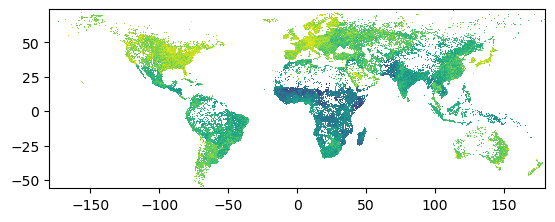

In [53]:
plt.imshow(raster, interpolation="nearest", extent=extent)

####  Write grid data product as a raster

In [54]:
raster.shape

(1300, 3600)

In [55]:
meta = {'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': np.nan,
 'width': 3600,
 'height': 1300,
 'count': 1,
'crs': "EPSG:4326",
'transform': Affine(0.1, 0.0, extent[0],
        0.0, -0.1, extent[3])
       }

raster_outpath = (data_dir + "preds/"
           "hdi_raster_predictions.tif")

with rasterio.open(raster_outpath , "w", **meta) as dest:
     dest.write(np.array([raster]))